# Load py_ballisticcalc and set units

In [1]:
from typing_extensions import Union
from py_ballisticcalc import (DragModel, TableG1, Distance, Weight, Ammo, Velocity, Weapon, Shot, Atmo, Wind,
                              Angular, Calculator, RangeError, HitResult, logger, PreferredUnits)
from py_ballisticcalc.unit import *
PreferredUnits.distance = Unit.Meter
PreferredUnits.velocity = Unit.MPS
PreferredUnits.drop = Unit.Meter

d:\Code\py-ballisticcalc\py_ballisticcalc\__init__.py:44: UserWarning: Library running in pure python mode. For better performance install 'py_ballisticcalc.exts' binary package
  warnings.warn("Library running in pure python mode. "


## Wrapper function to handle extreme scenarios

In [2]:
def must_fire(interface: Calculator, zero_shot, trajectory_range, extra_data, time_step,
              **kwargs) -> tuple[HitResult, Union[RangeError, None]]:
    try:
        return interface.fire(zero_shot, trajectory_range, **kwargs, extra_data=extra_data, time_step=time_step), None
    except RangeError as err:
        # Create HitResult with data that were calculated before trajectory exception reached
        return HitResult(zero_shot, err.incomplete_trajectory, extra=extra_data), err

# Ex.1: Shot hits minimum altitude before end of range

Using a projectile with a very low BC (meaning not very aerodynamic).  We simulate a shot starting at altitude of 1000m above ground level and ask for trajectory going 1000m downrange.  Simulation reports it hitting ground level before it can travel 1000m horizontally.

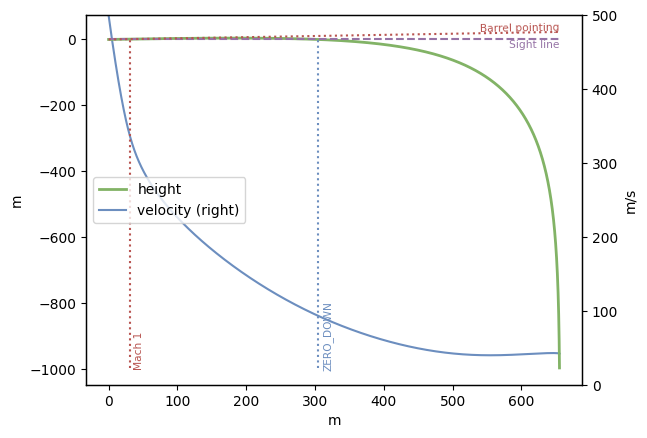

In [11]:
drag_model = DragModel(bc=0.03, drag_table=TableG1)  # Projectile has G1 BC of 0.03
zero = Shot(weapon=Weapon(),
            ammo=Ammo(drag_model, Velocity.MPS(500)),  # Muzzle velocity is 500m/s
            atmo=Atmo(altitude=Distance.Meter(1000)),  # Shot is fired at an altitude of 1000m ASL
            relative_angle=Angular.Degree(2.0)  # Point barrel 2° above horizon
            )

calc = Calculator(_config={
    "cMinimumVelocity": 0,  # Run simulation as long as velocity is non-zero
    "cMinimumAltitude": 0,  # Stop simulation at sea level
})

# Compute trajectory out to horizontal range of 1000m
hit_result, err = must_fire(calc, zero, Distance.Meter(1000), extra_data=True, time_step=0.1)

if err:
    logger.warning("%s, trajectory incomplete", err)

# Plot trajectory
from py_ballisticcalc.visualize.plot import show_hit_result_plot
#matplotlib.use('TkAgg')
p = hit_result.plot()
show_hit_result_plot()

## Inspect data
We can see that shot begins pointing 2° above horizon, but after 28 seconds and 655m travel downrange it has almost no forward velocity.  Instead it has reached its terminal velocity of 42m/s and is falling almost vertically.

In [12]:
df = hit_result.dataframe(True).drop(['target_drop', 'drop_adj', 'windage', 'windage_adj', 'look_distance', 'density_factor', 'energy', 'ogw', 'flag'], axis=1).set_index('distance')
#df.to_clipboard()
display(df.head(3))
display(df.tail(3))

,time,velocity,mach,height,angle,drag
distance,,,,,,
0.0 m,0.000 s,500 m/s,1.49 mach,-0.0 m,2.0000 °,0.000
0.1 m,0.000 s,499 m/s,1.48 mach,0.0 m,1.9998 °,6.813
0.2 m,0.000 s,499 m/s,1.48 mach,0.0 m,1.9997 °,6.807


,time,velocity,mach,height,angle,drag
distance,,,,,,
655.4 m,28.361 s,42 m/s,0.12 mach,-993.5 m,-89.7395 °,0.235
655.4 m,28.363 s,42 m/s,0.12 mach,-993.6 m,-89.7396 °,0.235
655.4 m,28.464 s,42 m/s,0.12 mach,-997.8 m,-89.7457 °,0.235


# Ex.2: Dropped Projectile
Same projectile, dropped from an altitude of 1000m

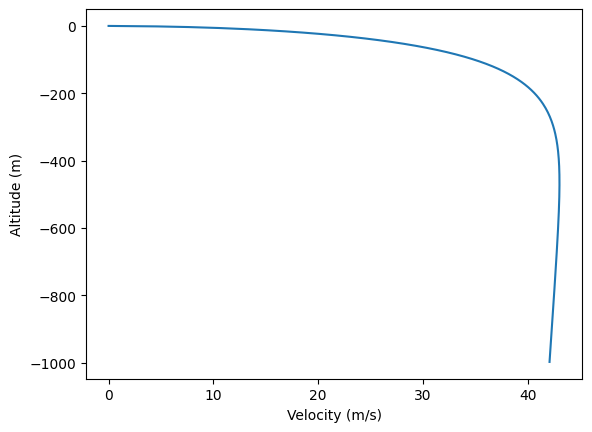

In [54]:
zero = Shot(weapon=Weapon(),
            ammo=Ammo(drag_model, Velocity.MPS(0)),  # Projectile starts with no velocity
            atmo=Atmo(altitude=Distance.Meter(1000)),  # Projectile dropped from an altitude of 1000m ASL
            )

hit_result, err = must_fire(calc, zero, Distance.Meter(1000), extra_data=True, time_step=0.1)
if err:
    logger.warning("%s, trajectory incomplete", err)

drop_df = hit_result.dataframe()
ax = drop_df.plot(x='velocity', y='height', xlabel='Velocity (m/s)', ylabel='Altitude (m)', legend=False)

## Inspect data
Maximum velocity of 43m/s is achieved after falling 463.9m.  Thereafter the terminal velocity decreases to 42m/s as the projectile encounters increasingly dense atmosphere.

In [55]:
df = hit_result.dataframe(True).drop(['distance', 'target_drop', 'drop_adj', 'windage', 'windage_adj', 'look_distance', 'energy', 'ogw', 'flag'], axis=1)
#df.to_clipboard()
max_velocity_row = drop_df[drop_df.velocity == drop_df.velocity.max()].index[0]
display(df[df.index == max_velocity_row])
df.tail(1)

,time,velocity,mach,height,angle,density_factor,drag
134,13.744 s,43 m/s,0.13 mach,-463.9 m,-90.0000 °,-5.025e-02,0.228


,time,velocity,mach,height,angle,density_factor,drag
258,26.266 s,42 m/s,0.12 mach,-997.5 m,-90.0000 °,-2.451e-04,0.235


# Ex.3: Plunging Fire
Same blunt projectile is fired at an elevation of 87° – nearly straight upwards.  So it will reach an apex and then fall back to ground.

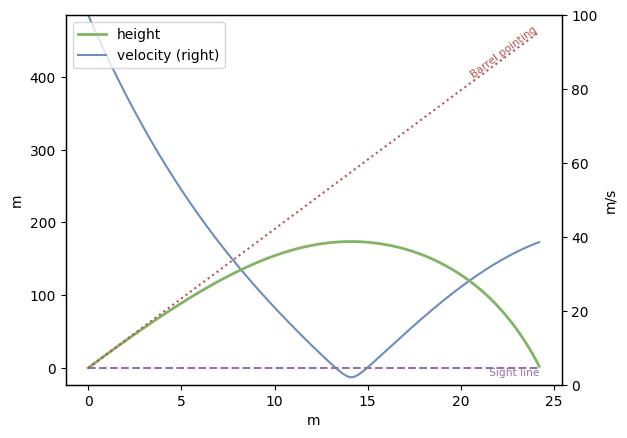

In [56]:
zero = Shot(weapon=Weapon(),
            ammo=Ammo(drag_model, Velocity.MPS(100)),
            relative_angle=Angular.Degree(87.0))

hit_result, err = must_fire(calc, zero, Distance.Meter(1000), extra_data=True, time_step=0.1)
if err:
    logger.warning("%s, trajectory incomplete", err)

p = hit_result.plot()
show_hit_result_plot()

## Apex data
Looking for the maximum observed height, we find the apex reached 5.025s after launch at a horizontal distance of 14.1m.

In [52]:
traj_df = hit_result.dataframe()
apex_row = traj_df[traj_df.height == traj_df.height.max()].index[0]

df = hit_result.dataframe(True).drop(['target_drop', 'drop_adj', 'windage', 'windage_adj', 'look_distance', 'density_factor', 'energy', 'ogw', 'flag'], axis=1)
df.loc[apex_row-1:apex_row+1]

,time,distance,velocity,mach,height,angle,drag
229,4.989 s,14.0 m,2 m/s,0.01 mach,173.7 m,17.9404 °,0.013
230,5.025 s,14.1 m,2 m/s,0.01 mach,173.7 m,8.5146 °,0.012
231,5.062 s,14.1 m,2 m/s,0.01 mach,173.7 m,-1.7978 °,0.012


# Ex.3: Strong-wind Reversing Trajectory
Here we loft the blunt projectile at 100m/s at a 70° elevation into a 20m/s headwind.  This windspeed blows the projectile backwards so that it impacts the ground behind the firing point.

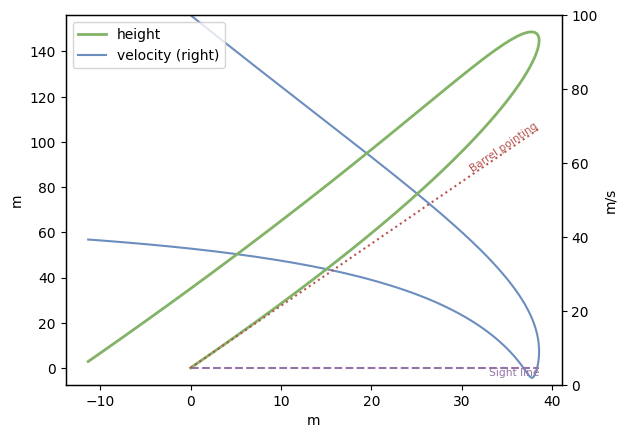

,distance,velocity,mach,height,angle,drag
time,,,,,,
10.506 s,-6.1 m,38 m/s,0.11 mach,17.6 m,-109.3792 °,0.208
10.607 s,-7.4 m,39 m/s,0.11 mach,13.9 m,-109.4792 °,0.209
10.707 s,-8.7 m,39 m/s,0.11 mach,10.3 m,-109.5783 °,0.210
10.808 s,-10.0 m,39 m/s,0.11 mach,6.6 m,-109.6768 °,0.211
10.909 s,-11.3 m,39 m/s,0.12 mach,2.8 m,-109.7763 °,0.212


In [58]:
zero = Shot(weapon=Weapon(),
            ammo=Ammo(drag_model, Velocity.MPS(100)),
            relative_angle=Angular.Degree(70.0))
zero.winds = [Wind(Velocity.MPS(20), Angular.OClock(6))]

hit_result, err = must_fire(calc, zero, Distance.Meter(1000), extra_data=True, time_step=0.1)
if err:
    logger.warning("%s, trajectory incomplete", err)

p = hit_result.plot()
show_hit_result_plot()

df = hit_result.dataframe(True).drop(['target_drop', 'drop_adj', 'windage', 'windage_adj', 'look_distance', 'density_factor', 'energy', 'ogw', 'flag'], axis=1).set_index('time')
df.to_clipboard()
df.tail()